In [1]:
from math import log
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from scipy.optimize import brentq
from scipy.stats import gumbel_r
from scipy.stats import norm
from torch import Tensor

from botorch.acquisition.objective import PosteriorTransform, ScalarizedPosteriorTransform
from botorch.models.model import Model
from botorch.posteriors import GPyTorchPosterior
from test.acquisition.test_max_value_entropy_search import MockModel, MockPosterior


# MESMockModel

In [2]:
class MESMockModel(MockModel):
    r"""Mock object that implements dummy methods and feeds through specified outputs"""

    def __init__(self, num_outputs=1, batch_shape=None):
        r"""
        Args:
            num_outputs: The number of outputs.
            batch_shape: The batch shape of the model. For details see
                `botorch.models.model.Model.batch_shape`.
        """
        super().__init__(None)
        self._num_outputs = num_outputs
        self._batch_shape = torch.Size() if batch_shape is None else batch_shape

    def posterior(
            self,
            X: Tensor,
            observation_noise: bool = False,
            posterior_transform: Optional[PosteriorTransform] = None,
    ) -> MockPosterior:
        m_shape = X.shape[:-1]
        r_shape = list(X.shape[:-2]) + [1, 1]
        mvn = MultivariateNormal(
            mean=torch.zeros(m_shape, dtype=X.dtype, device=X.device),
            covariance_matrix=torch.eye(
                m_shape[-1], dtype=X.dtype, device=X.device
            ).repeat(r_shape),
        )
        if self.num_outputs > 1:
            mvn = mvn = MultitaskMultivariateNormal.from_independent_mvns(
                mvns=[mvn] * self.num_outputs
            )
        posterior = GPyTorchPosterior(mvn)
        if posterior_transform is not None:
            return posterior_transform(posterior)
        return posterior

    def forward(self, X: Tensor) -> MultivariateNormal:
        return self.posterior(X).distribution

    @property
    def batch_shape(self) -> torch.Size:
        return self._batch_shape

    @property
    def num_outputs(self) -> int:
        return self._num_outputs


class NoBatchShapeMESMockModel(MESMockModel):
    # For some reason it's really hard to mock this property to raise a
    # NotImplementedError, so let's just make a class for it.
    @property
    def batch_shape(self) -> torch.Size:
        raise NotImplementedError

In [3]:
import botorch.acquisition.max_value_entropy_search

def _sample_max_value_Gumbel(
        model: Model,
        candidate_set: Tensor,
        num_samples: int,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
) -> Tensor:
    """Samples the max values by Gumbel approximation.

    Should generally be called within a `with torch.no_grad()` context.

    Args:
        model: A fitted single-outcome model.
        candidate_set: A `n x d` Tensor including `n` candidate points to
            discretize the design space.
        num_samples: Number of max value samples.
        posterior_transform: A PosteriorTransform. If using a multi-output model,
            a PosteriorTransform that transforms the multi-output posterior into a
            single-output posterior is required.
        maximize: If True, consider the problem a maximization problem.

    Returns:
        A `num_samples x num_fantasies` Tensor of posterior max value samples.
    """
    # define the approximate CDF for the max value under the independence assumption
    posterior = model.posterior(candidate_set, posterior_transform=posterior_transform)
    weight = 1.0 if maximize else -1.0
    mu = weight * posterior.mean
    sigma = posterior.variance.clamp_min(1e-8).sqrt()
    
    print(mu.shape, sigma.shape)
    # mu, sigma is (num_fantasies) X n X 1
    if len(mu.shape) == 3 and mu.shape[-1] == 1:
        mu = mu.squeeze(-1).T
        sigma = sigma.squeeze(-1).T
    # mu, sigma is now n X num_fantasies or n X 1
    print(mu.shape, sigma.shape)

    # bisect search to find the quantiles 25, 50, 75
    lo = (mu - 3 * sigma).min(dim=0).values
    hi = (mu + 5 * sigma).max(dim=0).values
    num_fantasies = mu.shape[1]
    print(num_fantasies)

    device = candidate_set.device
    dtype = candidate_set.dtype
    quantiles = torch.zeros(num_fantasies, 3, device=device, dtype=dtype)
    for i in range(num_fantasies):
        lo_, hi_ = lo[i], hi[i]
        N = norm(mu[:, i].cpu().numpy(), sigma[:, i].cpu().numpy())
        quantiles[i, :] = torch.tensor(
            [
                brentq(lambda y: np.exp(np.sum(N.logcdf(y))) - p, lo_, hi_)
                for p in [0.25, 0.50, 0.75]
            ]
        )
    q25, q50, q75 = quantiles[:, 0], quantiles[:, 1], quantiles[:, 2]
    # q25, q50, q75 are 1 dimensional tensor with size of either 1 or num_fantasies

    # parameter fitting based on matching percentiles for the Gumbel distribution
    b = (q25 - q75) / (log(log(4.0 / 3.0)) - log(log(4.0)))
    a = q50 + b * log(log(2.0))

    # inverse sampling from the fitted Gumbel CDF distribution
    sample_shape = (num_samples, num_fantasies)
    eps = torch.rand(*sample_shape, device=device, dtype=dtype)
    max_values = a - b * eps.log().mul(-1.0).log()

    return max_values  # num_samples x num_fantasies


# Test

In [4]:
torch.manual_seed(7)

# Test with single-output model.
mm = MESMockModel()
candidate_set = torch.rand(3, 10, 2, device='cpu', dtype=torch.float32)  # Adjust device and dtype as needed
samples = _sample_max_value_Gumbel(mm, candidate_set=candidate_set, num_samples=5)
assert samples.shape == torch.Size([5, 3])

# Test with multi-output model w/ transform.
mm = MESMockModel(num_outputs=2)
pt = ScalarizedPosteriorTransform(
    weights=torch.ones(2, device='cpu', dtype=torch.float32)  # Adjust device and dtype as needed
)
samples = _sample_max_value_Gumbel(
    mm, candidate_set, 5, posterior_transform=pt
)
assert samples.shape == torch.Size([5, 3])

torch.Size([3, 10, 1]) torch.Size([3, 10, 1])
torch.Size([10, 3]) torch.Size([10, 3])
3
torch.Size([3, 10, 1]) torch.Size([3, 10, 1])
torch.Size([10, 3]) torch.Size([10, 3])
3


# Gumbel

In [10]:
mean, var, skew, kurt = gumbel_r.stats(moments='mvsk')
mean, var, skew, kurt


(0.5772156649015329, 1.6449340668482264, 1.1395470994046486, 2.4)

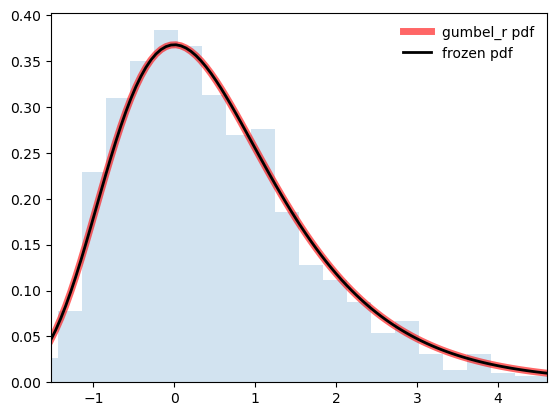

In [5]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(gumbel_r.ppf(0.01),
                gumbel_r.ppf(0.99), 100)
ax.plot(x, gumbel_r.pdf(x),
        'r-', lw=5, alpha=0.6, label='gumbel_r pdf')

rv = gumbel_r()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

r = gumbel_r.rvs(size=1000)

ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [9]:
test = [0.25, 0.5, 0.75]
vals = gumbel_r.ppf(test)
print(vals)
np.allclose(test, gumbel_r.cdf(vals))

[-0.32663426  0.36651292  1.24589932]


True

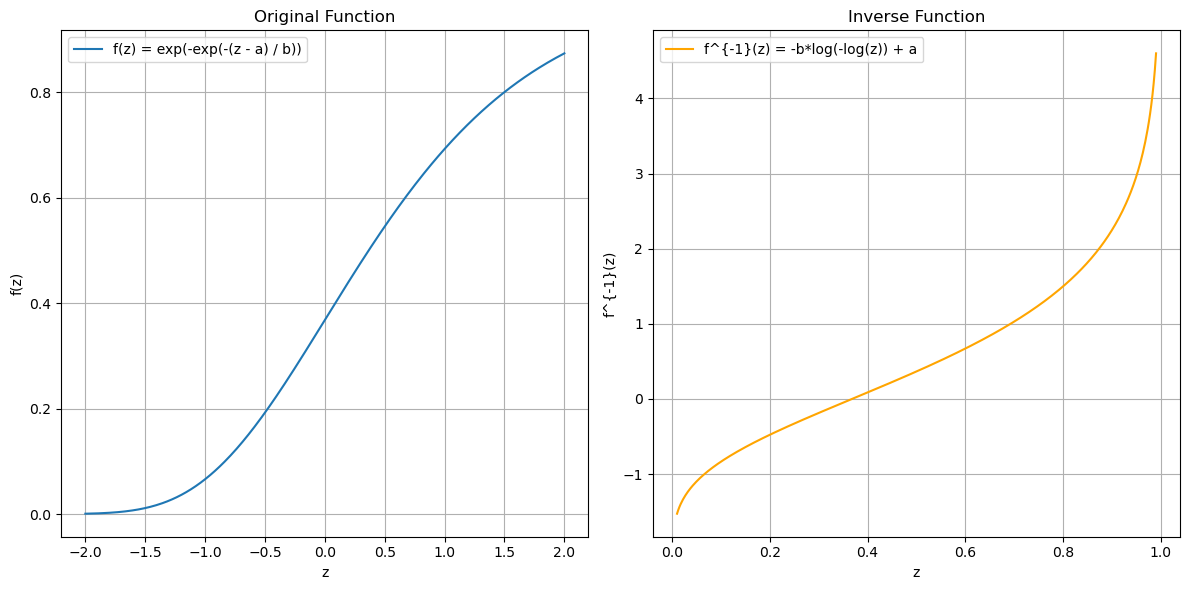

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the original function
def func(z, a=0, b=1):
    return np.exp(-np.exp(-(z - a) / b))

# Define the inverse function
def inverse_func(z, a=0, b=1):
    return -b * np.log(-np.log(z)) + a

# Create a range of z values
z = np.linspace(-2, 2, 400)
z_inv = np.linspace(0.01, 0.99, 400)  # Avoiding 0 and 1 for the inverse function

# Calculate function values
y = func(z)
y_inv = inverse_func(z_inv)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the original function
ax1.plot(z, y, label='f(z) = exp(-exp(-(z - a) / b))')
ax1.set_xlabel('z')
ax1.set_ylabel('f(z)')
ax1.set_title('Original Function')
ax1.legend()
ax1.grid(True)

# Plotting the inverse function
ax2.plot(z_inv, y_inv, label='f^{-1}(z) = -b*log(-log(z)) + a', color='orange')
ax2.set_xlabel('z')
ax2.set_ylabel('f^{-1}(z)')
ax2.set_title('Inverse Function')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
